In [ ]:
!git pull https://github.com/rosaj/p2p_sgd.git

In [1]:
from data.metrics import convert_to_global_vector, get_avg_distance, multiprocess_get_avg_distance
from common.util import save_json

# MNIST

In [2]:
import numpy as np
import tensorflow.keras.datasets.mnist as mnist
(t_x, t_y), (v_x, v_y) = mnist.load_data()

In [3]:
# BrendanMcMahan2017
# IID - the data is shuffled, and then partitioned into 100 clients each receiving 600 examples

tr_ds = np.array(t_y)
np.random.shuffle(tr_ds)
tr_ds = np.array_split(tr_ds, 100)

ds = convert_to_global_vector(tr_ds, 10)
js_dis, matrix = get_avg_distance(ds)
save_json("log/data/mnist_iid_100_clients.json", matrix)
print(js_dis)

Saved to log/data/mnist_iid_100_clients.json
0.005735671363813857


In [4]:
# BrendanMcMahan2017
# Non-IID, where we first sort the data by digit label,
# divide it into 200 shards of size 300, and assign each of 100 clients 2 shards.
# This is a pathological non-IID partition of the data, as most clients will only have examples of two digits.

tr_ds = t_y.copy()
tr_ds.sort()
tr_ds = np.array_split(tr_ds, 200)
np.random.shuffle(tr_ds)
tr_ds = [np.concatenate((tr_ds[i], tr_ds[i + 1])) for i in range(0, 200, 2)]

ds = convert_to_global_vector(tr_ds, 10)
js_dis, matrix = get_avg_distance(ds)
save_json("log/data/mnist_pathological-non-iid_100_clients.json", matrix)
print(js_dis)

Saved to log/data/mnist_pathological-non-iid_100_clients.json
0.8116621699040922


In [5]:
# Huang2020
# A practical non-IID data

tr_ds = np.array(t_y)
cls, cls_count = np.unique(tr_ds, return_counts=True)
n_groups, n_clients = 5, 100
group_clients = int(n_clients / n_groups)
sample_pct = (0.8, 0.2)

def class_examples(clazz):
    return cls_count[cls == clazz][0]

def reduce_examples(clazz, amount):
    cls_count[cls == clazz] -= amount

def other_groups(m_group):
    return [c for c in cls if c not in m_group]

dts = np.array_split(cls, n_groups)
clients = {k: [0] * len(cls) for k in range(n_clients)}
for i_g, group in enumerate(dts):
    for c_g in group:
        c_cnt = int(class_examples(c_g) * sample_pct[0])
        reduce_examples(c_g, c_cnt)
        cnt_per_client = int(c_cnt / group_clients)
        for gc in range(i_g * group_clients,  i_g * group_clients + group_clients):
            clients[gc][c_g] += cnt_per_client

for i_g, group in enumerate(dts):    
    for c_g in other_groups(group):
        c_cnt = int(class_examples(c_g) * sample_pct[1])
        cnt_per_client = int(c_cnt / group_clients)
        for gc in range(i_g * group_clients,  i_g * group_clients + group_clients):
            clients[gc][c_g] += cnt_per_client
        

js_dis, matrix = get_avg_distance(list(clients.values()))
save_json("log/data/mnist_practical-non-iid_100_clients.json", matrix)
print(js_dis)

Saved to log/data/mnist_practical-non-iid_100_clients.json
0.5229415784515135


In [6]:
list(clients.values())

[[236, 269, 11, 12, 11, 10, 11, 12, 11, 11],
 [236, 269, 11, 12, 11, 10, 11, 12, 11, 11],
 [236, 269, 11, 12, 11, 10, 11, 12, 11, 11],
 [236, 269, 11, 12, 11, 10, 11, 12, 11, 11],
 [236, 269, 11, 12, 11, 10, 11, 12, 11, 11],
 [236, 269, 11, 12, 11, 10, 11, 12, 11, 11],
 [236, 269, 11, 12, 11, 10, 11, 12, 11, 11],
 [236, 269, 11, 12, 11, 10, 11, 12, 11, 11],
 [236, 269, 11, 12, 11, 10, 11, 12, 11, 11],
 [236, 269, 11, 12, 11, 10, 11, 12, 11, 11],
 [236, 269, 11, 12, 11, 10, 11, 12, 11, 11],
 [236, 269, 11, 12, 11, 10, 11, 12, 11, 11],
 [236, 269, 11, 12, 11, 10, 11, 12, 11, 11],
 [236, 269, 11, 12, 11, 10, 11, 12, 11, 11],
 [236, 269, 11, 12, 11, 10, 11, 12, 11, 11],
 [236, 269, 11, 12, 11, 10, 11, 12, 11, 11],
 [236, 269, 11, 12, 11, 10, 11, 12, 11, 11],
 [236, 269, 11, 12, 11, 10, 11, 12, 11, 11],
 [236, 269, 11, 12, 11, 10, 11, 12, 11, 11],
 [236, 269, 11, 12, 11, 10, 11, 12, 11, 11],
 [11, 13, 238, 245, 11, 10, 11, 12, 11, 11],
 [11, 13, 238, 245, 11, 10, 11, 12, 11, 11],
 [11, 13, 

# Reddit

In [1]:
from data.metrics import convert_to_global_vector, get_avg_distance, multiprocess_get_avg_distance
from common.util import save_json
from data import clients_data
import numpy as np

train, val, test = clients_data.load_clients_data(3_000)
rnd_ind = np.random.choice(len(train), size=100, replace=False)
train_ds = [train[i][1][train[i][1] != 1] for i in range(len(train)) if i in rnd_ind] # 1-> OOV token, 0-> padding

tr_ds = convert_to_global_vector([a - 2 for a in train_ds], 10_000)
js_dis, matrix = multiprocess_get_avg_distance(tr_ds)
save_json("log/data/reddit_100_clients.json", matrix)
print(js_dis)

Saved to log/data/reddit_100_clients.json
0.6633995418494718


# Visualisation

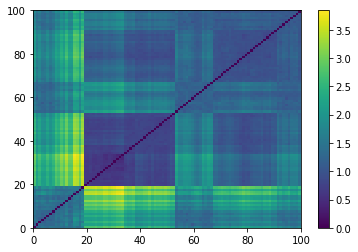

In [2]:
from plot.data import plot_colormesh, read_symmetric_matrix
plot_colormesh(read_symmetric_matrix('data/reddit_100_clients'), 'complete')